In [40]:
import pandas as pd
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Read the CSV file
selected_station_data = pd.read_csv('selected_station_data_100.csv')

# Parse the nested `Values` column
selected_station_data['Values'] = selected_station_data['Values'].apply(
    lambda x: list(map(float, x.strip("[]").split(", ")))
)

# Get the list of all stations
stations = selected_station_data['Station_ID'].unique()

# Function to calculate MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Auto ARIMA forecasting
arima_results = {"station": [], "steps": [], "mse": [], "mae": [], "mape": []}
forecast_steps = [1, 3, 7]

for station in stations:
    print(f"Processing station: {station}")
    # Extract the time series for the current station
    values = selected_station_data[selected_station_data['Station_ID'] == station]['Values'].iloc[0]
    train_data = values[:-7]  # Use earlier data for training
    test_data = values[-7:]  # Use the last 7 days for testing

    # Create and fit the ARIMA model
    model = auto_arima(train_data, seasonal=False, trace=True, error_action="ignore", suppress_warnings=True)

    # Forecast for specified steps
    for step in forecast_steps:
        predictions = model.predict(n_periods=step)

        # Calculate error metrics
        mse = mean_squared_error(test_data[:step], predictions)
        mae = mean_absolute_error(test_data[:step], predictions)
        mape = calculate_mape(np.array(test_data[:step]), np.array(predictions))

        # Store results
        arima_results["station"].append(station)
        arima_results["steps"].append(step)
        arima_results["mse"].append(mse)
        arima_results["mae"].append(mae)
        arima_results["mape"].append(mape)

# Convert results to a DataFrame for display
arima_results_df = pd.DataFrame(arima_results)
print("\nAuto ARIMA model forecasting results:")
print(arima_results_df)

# Save the results to a CSV file
arima_results_df.to_csv("auto_arima_results_with_errors_100.csv", index=False)
print("Results have been saved to 'auto_arima_results_with_errors_100.csv'")


Processing station: 1006
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2321.604, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2371.471, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2372.575, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2372.234, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2369.497, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2325.257, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2325.578, Time=0.31 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2323.005, Time=0.65 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2323.092, Time=0.73 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2329.510, Time=0.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2326.952, Time=0.69 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2327.431, Time=0.49 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2321.861, Time=0.94 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2319.753, Time=0.26 sec
 ARIMA(1

In [41]:
# Save the results to a CSV file
arima_results_df.to_csv("auto_arima_results_100.csv", index=False)
print("Results have been saved to 'auto_arima_results_100.csv'")

# Display the DataFrame
arima_results_df


结果已保存至 'auto_arima_results_100.csv'


,station,steps,mse,mae,mape
0,1006,1,0.049664,0.222854,0.739867
1,1006,3,1.194755,0.956821,3.091671
2,1006,7,1.301113,1.065752,3.475672
3,23878,1,2.014893,1.419469,8.513411
4,23878,3,1.229392,1.081954,6.952271
...,...,...,...,...,...
295,22049,3,1.181112,0.823000,4.408393
296,22049,7,5.479051,1.603172,10.531227
297,22841,1,0.086491,0.294094,1.507245
298,22841,3,0.198519,0.404083,2.247270


In [59]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Read the CSV file
selected_station_data = pd.read_csv('selected_station_data_100.csv')

# Parse the nested `Values` column
selected_station_data['Values'] = selected_station_data['Values'].apply(
    lambda x: list(map(float, x.strip("[]").split(", ")))
)

# Get the list of all stations
stations = selected_station_data['Station_ID'].unique()

# LSTM parameters
seq_length = 28  # Use the past 28 days of data for predictions
forecast_steps = [1, 3, 7]

# Add MAE and MAPE calculation
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Store results
lstm_results = {"station": [], "steps": [], "mse": [], "mae": [], "mape": []}

# Iterate through stations
for station in stations:
    print(f"Processing station: {station}")
    # Extract the time series for the current station
    values = selected_station_data[selected_station_data['Station_ID'] == station]['Values'].iloc[0]
    train_data = values[:-7]  # Use earlier data for training
    test_data = values[-7:]  # Use the last 7 days for testing

    # Normalize data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(np.array(train_data).reshape(-1, 1))

    # Prepare LSTM input data
    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i + seq_length])
            y.append(data[i + seq_length])
        return np.array(X), np.array(y)

    X_train, y_train = create_sequences(train_scaled, seq_length)

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Train the LSTM model
    early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])

    # Use the model for predictions
    for step in forecast_steps:
        X_test = train_scaled[-seq_length:].reshape(1, seq_length, 1)  # Last training sequence
        predictions = []
        for _ in range(step):
            pred = model.predict(X_test, verbose=0)
            predictions.append(pred[0][0])
            X_test = np.roll(X_test, -1, axis=1)  # Update sliding window
            X_test[0, -1, 0] = pred

        # Inverse transform predictions
        predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

        # Calculate error metrics
        mse = mean_squared_error(test_data[:step], predictions)
        mae = mean_absolute_error(test_data[:step], predictions)
        mape = calculate_mape(np.array(test_data[:step]), np.array(predictions))

        lstm_results["station"].append(station)
        lstm_results["steps"].append(step)
        lstm_results["mse"].append(mse)
        lstm_results["mae"].append(mae)
        lstm_results["mape"].append(mape)

# Convert results to a DataFrame for display
lstm_results_df = pd.DataFrame(lstm_results)
print("\nLSTM model forecasting results:")
print(lstm_results_df)

# Save results to a CSV file
lstm_results_df.to_csv("lstm_results_with_errors.csv", index=False)
print("Results have been saved to 'lstm_results_with_errors.csv'")


Processing station: 1006


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 23878


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 28004


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 29063


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 29077


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 29127


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 31011


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 5094


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 32040


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 33119


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 33247


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 37039


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 39128


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 39326


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 1020


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 40093


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 40211


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 40717


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 40764


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 41359


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 48237


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 48245


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 50137


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 54038


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 56238


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 58012


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 58161


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 9021


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 58212


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 61250


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 61375


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 63292


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 9053


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 65111


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 67105


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 68257


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 69139


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 2012


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 70339


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 72162


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 74258


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 76031


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 9225


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 78015


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 79105


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 80091


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 81123


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 81125


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 82139


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 9518


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 83090


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 84143


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 85096


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 86038


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 86077


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 9538


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 86104


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 86361


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 87168


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 9542


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 88051


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 88162


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 89002


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 90175


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 90180


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 91107


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 91126


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 91306


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 91311


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 91331


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 92123


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 95003


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 96033


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 97072


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 97080


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 97083


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 97085


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 98017


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 9961


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 10916


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 10917


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 14277


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 14405


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 14508


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 3093


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 14901


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 14932


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 14948


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 14954


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 15602


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 15635


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 16001


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 16097


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 18120


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 18201


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 18217


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 4083


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 22031


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 22049


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi

Processing station: 22841


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test[0, -1, 0] = pred
C:\Users\User\AppData\Local\Temp\ipykernel_25228\2153974219.py:72: DeprecationWarning: Conversi


LSTM 模型预测结果：
     station  steps       mse       mae       mape
0       1006      1  0.243811  0.493772   1.639304
1       1006      3  2.864191  1.520953   4.918966
2       1006      7  4.244299  1.960034   6.405886
3      23878      1  0.190620  0.436600   2.618553
4      23878      3  0.393049  0.610123   4.019983
..       ...    ...       ...       ...        ...
295    22049      3  0.555922  0.608063   3.334371
296    22049      7  8.543284  2.084249  13.667347
297    22841      1  0.011858  0.108895   0.558094
298    22841      3  1.311511  0.964827   5.546051
299    22841      7  3.501433  1.353725   9.910139

[300 rows x 5 columns]
结果已保存至 'lstm_results_with_errors.csv'


In [60]:
# Save the results to a CSV file
lstm_results_df.to_csv("lstm_results_100.csv", index=False)
print("Results have been saved to 'lstm_results_100.csv'")

# Display the DataFrame
lstm_results_df


结果已保存至 'lstm_results.csv_100'


,station,steps,mse,mae,mape
0,1006,1,0.243811,0.493772,1.639304
1,1006,3,2.864191,1.520953,4.918966
2,1006,7,4.244299,1.960034,6.405886
3,23878,1,0.190620,0.436600,2.618553
4,23878,3,0.393049,0.610123,4.019983
...,...,...,...,...,...
295,22049,3,0.555922,0.608063,3.334371
296,22049,7,8.543284,2.084249,13.667347
297,22841,1,0.011858,0.108895,0.558094
298,22841,3,1.311511,0.964827,5.546051


In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the ARIMA and LSTM results CSV files
arima_results_df = pd.read_csv("auto_arima_results_100.csv")
lstm_results_df = pd.read_csv("lstm_results_100.csv")

# Initialize a dictionary for comparison results
comparison = {
    "Model": [],
    "Steps": [],
    "Mean MSE": [],
    "Total MSE": [],
    "Mean MAE": [],
    "Total MAE": [],
    "Mean MAPE": [],
    "Total MAPE": []
}

# Define a function to calculate MAPE
def calculate_mape(y_true, y_pred):
    return (abs((y_true - y_pred) / y_true).replace([float('inf'), -float('inf')], 0).fillna(0)).mean() * 100

# Compare results for the specified forecast steps
forecast_steps = [1, 3, 7]
for step in forecast_steps:
    # Filter results for the current step
    arima_step = arima_results_df[arima_results_df["steps"] == step]
    lstm_step = lstm_results_df[lstm_results_df["steps"] == step]
    
    # Compute metrics for the ARIMA model
    arima_mean_mse = arima_step["mse"].mean()
    arima_total_mse = arima_step["mse"].sum()
    arima_mean_mae = arima_step["mae"].mean()
    arima_total_mae = arima_step["mae"].sum()
    arima_mean_mape = arima_step["mape"].mean()
    arima_total_mape = arima_step["mape"].sum()
    
    # Add ARIMA metrics to the comparison dictionary
    comparison["Model"].append("ARIMA")
    comparison["Steps"].append(f"{step}-Day")
    comparison["Mean MSE"].append(arima_mean_mse)
    comparison["Total MSE"].append(arima_total_mse)
    comparison["Mean MAE"].append(arima_mean_mae)
    comparison["Total MAE"].append(arima_total_mae)
    comparison["Mean MAPE"].append(arima_mean_mape)
    comparison["Total MAPE"].append(arima_total_mape)
    
    # Compute metrics for the LSTM model
    lstm_mean_mse = lstm_step["mse"].mean()
    lstm_total_mse = lstm_step["mse"].sum()
    lstm_mean_mae = lstm_step["mae"].mean()
    lstm_total_mae = lstm_step["mae"].sum()
    lstm_mean_mape = lstm_step["mape"].mean()
    lstm_total_mape = lstm_step["mape"].sum()
    
    # Add LSTM metrics to the comparison dictionary
    comparison["Model"].append("LSTM")
    comparison["Steps"].append(f"{step}-Day")
    comparison["Mean MSE"].append(lstm_mean_mse)
    comparison["Total MSE"].append(lstm_total_mse)
    comparison["Mean MAE"].append(lstm_mean_mae)
    comparison["Total MAE"].append(lstm_total_mae)
    comparison["Mean MAPE"].append(lstm_mean_mape)
    comparison["Total MAPE"].append(lstm_total_mape)

# Convert the comparison dictionary into a DataFrame
comparison_df = pd.DataFrame(comparison)

# Display the comparison results
print("\nARIMA vs LSTM Comparison Results:")
print(comparison_df)

# Save the comparison results to a CSV file
comparison_df.to_csv("model_comparison_with_mae_mape.csv", index=False)
print("Comparison results have been saved to 'model_comparison_with_mae_mape.csv'")



ARIMA vs LSTM 对比结果：
   Model  Steps  Mean MSE   Total MSE  Mean MAE   Total MAE  Mean MAPE  \
0  ARIMA  1-Day  2.789670  278.966978  1.204570  120.456996   6.467521   
1   LSTM  1-Day  4.576184  457.618420  1.448339  144.833932   7.790066   
2  ARIMA  3-Day  2.592021  259.202139  1.234957  123.495669   6.905605   
3   LSTM  3-Day  3.808607  380.860728  1.449401  144.940056   8.115952   
4  ARIMA  7-Day  4.384272  438.427203  1.515821  151.582133  15.219797   
5   LSTM  7-Day  5.458046  545.804589  1.695984  169.598403  15.658678   

    Total MAPE  
0   646.752055  
1   779.006600  
2   690.560533  
3   811.595188  
4  1521.979742  
5  1565.867819  
对比结果已保存至 'model_comparison_with_mae_mape.csv'


<Figure size 600x400 with 0 Axes>

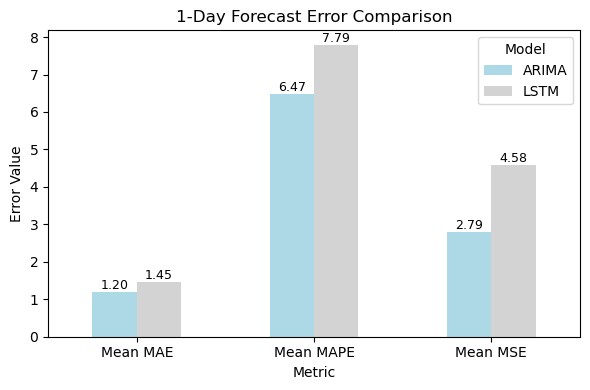

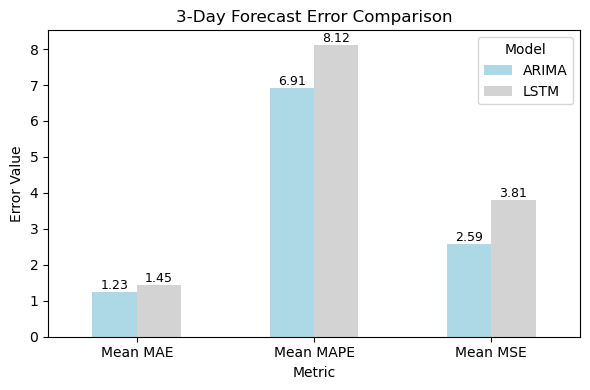

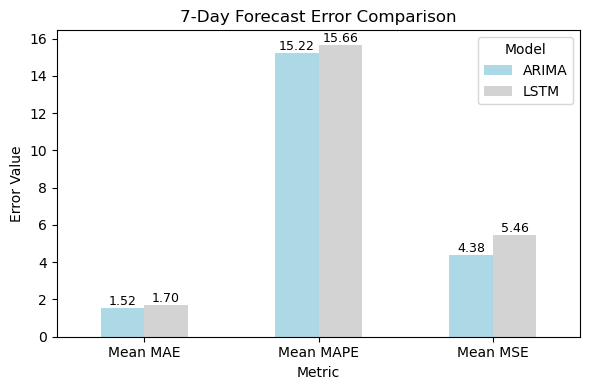

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the ARIMA and LSTM results CSV files
arima_results_df = pd.read_csv("auto_arima_results_with_errors.csv")
lstm_results_df = pd.read_csv("lstm_results_with_errors.csv")

# Define metrics, models, and forecast steps
metrics = ["mse", "mae", "mape"]
models = ["ARIMA", "LSTM"]
forecast_steps = [1, 3, 7]

# Prepare comparison data
comparison_data = []

for model, df in zip(models, [arima_results_df, lstm_results_df]):
    for step in forecast_steps:
        step_data = df[df["steps"] == step]
        mean_errors = step_data[metrics].mean()
        total_errors = step_data[metrics].sum()
        comparison_data.append([model, step, "Mean MSE", mean_errors["mse"]])
        comparison_data.append([model, step, "Mean MAE", mean_errors["mae"]])
        comparison_data.append([model, step, "Mean MAPE", mean_errors["mape"]])

# Convert comparison data to DataFrame
comparison_df = pd.DataFrame(comparison_data, columns=["Model", "Steps", "Metric", "Value"])

# Define bar chart colors
colors = ["lightblue", "lightpink"]

# Plot bar charts for each forecast step
for step in forecast_steps:
    subset = comparison_df[comparison_df["Steps"] == step]
    ax = subset.pivot(index="Metric", columns="Model", values="Value").plot(
        kind="bar",
        figsize=(6, 4),
        color=colors,
        title=f"{step}-Day Forecast Error Comparison",
        ylabel="Error Value",
    )
    # Set x-axis labels to display horizontally
    plt.xticks(rotation=0, ha="center")
    
    # Add value labels to each bar
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=9)
    
    plt.tight_layout()
    plt.show()


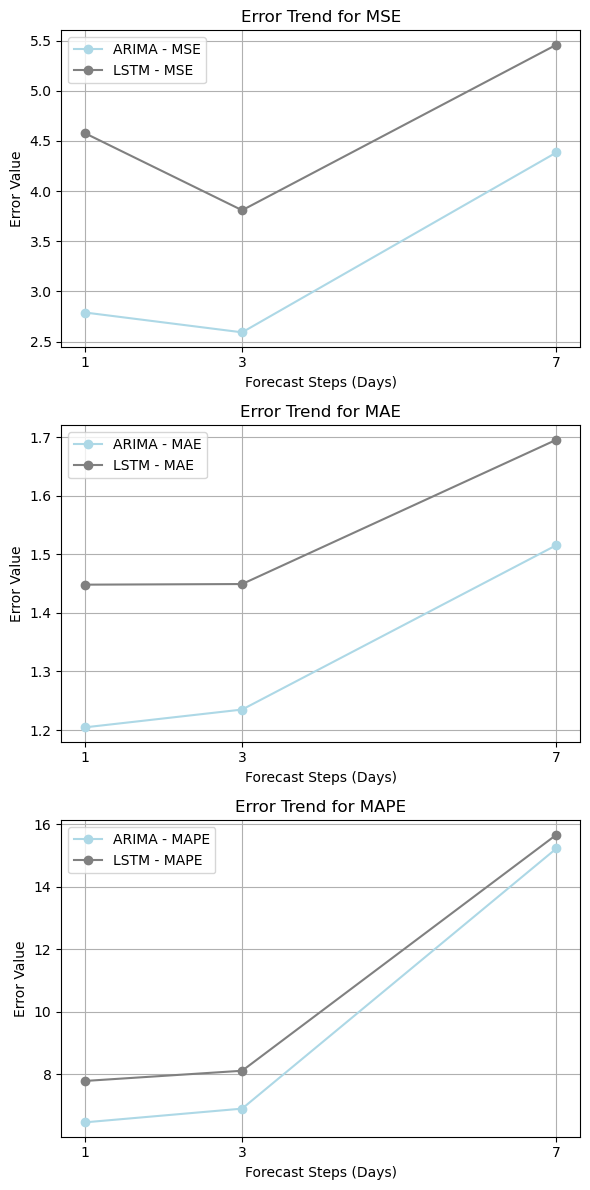

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

# Read ARIMA and LSTM results CSV files
arima_results_df = pd.read_csv("auto_arima_results_with_errors.csv")
lstm_results_df = pd.read_csv("lstm_results_with_errors.csv")

# Aggregate data to compute mean errors
forecast_steps = [1, 3, 7]
metrics = ["mse", "mae", "mape"]
models = ["ARIMA", "LSTM"]

# Prepare data
error_trends = []

for model, df in zip(models, [arima_results_df, lstm_results_df]):
    for step in forecast_steps:
        step_data = df[df["steps"] == step]
        mean_errors = step_data[metrics].mean()
        for metric in metrics:
            error_trends.append([model, step, metric, mean_errors[metric]])

# Convert to DataFrame
error_trends_df = pd.DataFrame(error_trends, columns=["Model", "Steps", "Metric", "Value"])

# Plot line charts
plt.figure(figsize=(6, 12))

colors = {"ARIMA": "lightblue", "LSTM": "gray"}  # Define colors for models

for metric in metrics:
    plt.subplot(3, 1, metrics.index(metric) + 1)
    for model in models:
        subset = error_trends_df[(error_trends_df["Model"] == model) & (error_trends_df["Metric"] == metric)]
        plt.plot(
            subset["Steps"], 
            subset["Value"], 
            marker="o", 
            color=colors[model], 
            label=f"{model} - {metric.upper()}"
        )
    plt.title(f"Error Trend for {metric.upper()}")
    plt.xlabel("Forecast Steps (Days)")
    plt.ylabel("Error Value")
    plt.xticks(ticks=[1, 3, 7], labels=["1", "3", "7"])  # Show only 1, 3, 7
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()
